In [1]:
import json
from enum import Enum
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
from graph import TYPES_OF_GRAPH

In [90]:
class Graph:
    def __init__(self, graph: dict, type: TYPES_OF_GRAPH) -> None:
        if type == TYPES_OF_GRAPH.MULTI:
            self.nx_graph = nx.MultiDiGraph()
        else:
            self.nx_graph = nx.DiGraph()
        self.type = type
        self.graph_degrees = []
        for node in graph['nodes']:
            self.nx_graph.add_node(node['id'], responses=node['response'])
        for link in graph['edges']:
            first = link['source']
            second = link['target']
            self.nx_graph.add_edges_from([(first, second, {"requests": link['request']})])

In [84]:
def find_split_nodes(g1, g2):
    # Create dictionaries to map edges based on 'requests' attribute
    g1_requests = {}
    g2_requests = {}

    g1_edges = {}
    g2_edges = {}

    for u, v, data in g1.edges(data=True):
        request = data.get('requests')
        if request not in g1_requests:
            g1_requests[request] = []
        g1_requests[request].append((u, v))

    for u, v, data in g2.edges(data=True):
        request = data.get('requests')
        if request not in g2_requests:
            g2_requests[request] = []
        g2_requests[request].append((u, v))

    for u, v, data in g1.edges(data=True):
        key=f'{u}->{v}'
        if key not in g1_edges:
            g1_edges[key] = []
        g1_edges[key].append(*data.values())

    for u, v, data in g2.edges(data=True):
        key=f'{u}->{v}'
        if key not in g2_edges:
            g2_edges[key] = []
        g2_edges[key].append(*data.values())
    
    g1_split = {}
    g2_split = {}
    for edge, data in g1_edges.items():
        if len(data) > 1 and len(g2_edges[edge]) < len(data):
                g1_node = int(edge.split('->')[1])
                g2_end_nodes = []
                for request in data:
                    end_node = g2_requests[request][0][1]
                    g2_end_nodes.append(end_node)
                print(f"in g1 Node {g1_node} is split into {g2_end_nodes} in g2")
                g1_split[g1_node] = g2_end_nodes
    for edge, data in g2_edges.items():
        if len(data) > 1 and len(g1_edges[edge]) < len(data):
                g2_node = int(edge.split('->')[1])
                g1_end_nodes = []
                for request in data:
                    end_node = g1_requests[request][0][1]
                    g1_end_nodes.append(end_node)
                print(f"in g2 Node {g2_node} is split into {g1_end_nodes} in g1")
                g2_split[g2_node] = g1_end_nodes
                
    return g1_split,g2_split 

In [85]:
def do_mapping(g1, g2):
    GM = nx.isomorphism.DiGraphMatcher(g1, g2, edge_match=lambda x, y: set(x['requests']).intersection(set( y['requests'])) is not None)
    are_isomorphic = GM.is_isomorphic()
    if are_isomorphic:
        print("Graphs are isomorphic and correct")
        mapping = nx.vf2pp_isomorphism(g1, g2, node_label=None)
        return mapping
    mapping = {}
    for i in range(1, len(g1.nodes)):
        mapping[i] = i
    g1_unmatched_nodes, g2_unmatched_nodes = find_split_nodes(g1, g2)
    print(g1_unmatched_nodes)
    print(g2_unmatched_nodes)
    for k, v in g1_unmatched_nodes.items():
        elem = random.choice(v)
        mapping[k] = elem
        for node in v:
            if node != elem:
                mapping[node] = None
    print(mapping)

In [86]:
def get_edge_labels(graph):
    edge_labels = {}
    for u,v,d in graph.edges(data=True):
        if edge_labels.get((u,v,)) is not None:
            existing_value = edge_labels[(u,v,)]
            edge_labels[(u,v,)] = existing_value + ';\n' + d['requests']
        else:
            edge_labels[(u,v,)] = d['requests']
    return edge_labels

## Проверяем на изоморфизм

In [57]:
with open('./identical_except_numbering/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_except_numbering/generated_graph.json', 'r') as g:
    generated = json.load(g)

ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
G1 = ground_truth_graph.nx_graph
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)
G2 = ground_truth_graph.nx_graph

In [226]:
ground_truth_graph.nx_graph.edges

OutEdgeView([(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (4, 2), (5, 6), (6, 7)])

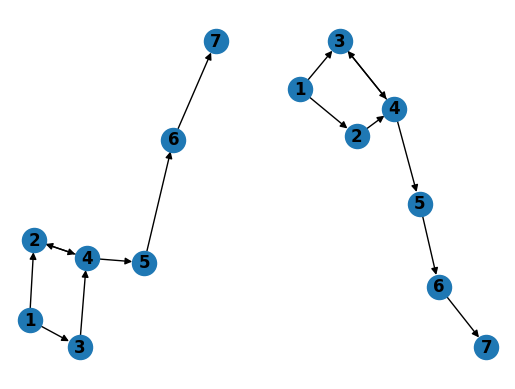

In [59]:
subax1 = plt.subplot(121)
nx.draw(ground_truth_graph.nx_graph, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(generated_graph.nx_graph, with_labels=True, font_weight='bold')

In [227]:
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

### Проверим на изоморфичность в случае, когда на ребрах несколько реплик, но графы одинаковы

In [228]:
with open('./identical_with_several_requests/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_with_several_requests/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [229]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)

In [232]:
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

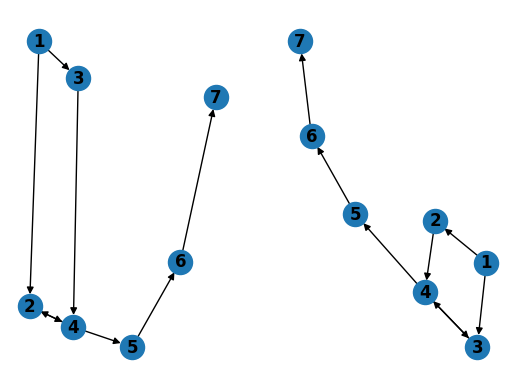

In [53]:

subax1 = plt.subplot(121)
nx.draw(ground_truth_graph.nx_graph, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(generated_graph.nx_graph, with_labels=True, font_weight='bold')

### Проверка когда есть несоотвествие

In [11]:
with open('./nonidentical_graphs/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./nonidentical_graphs/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [15]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

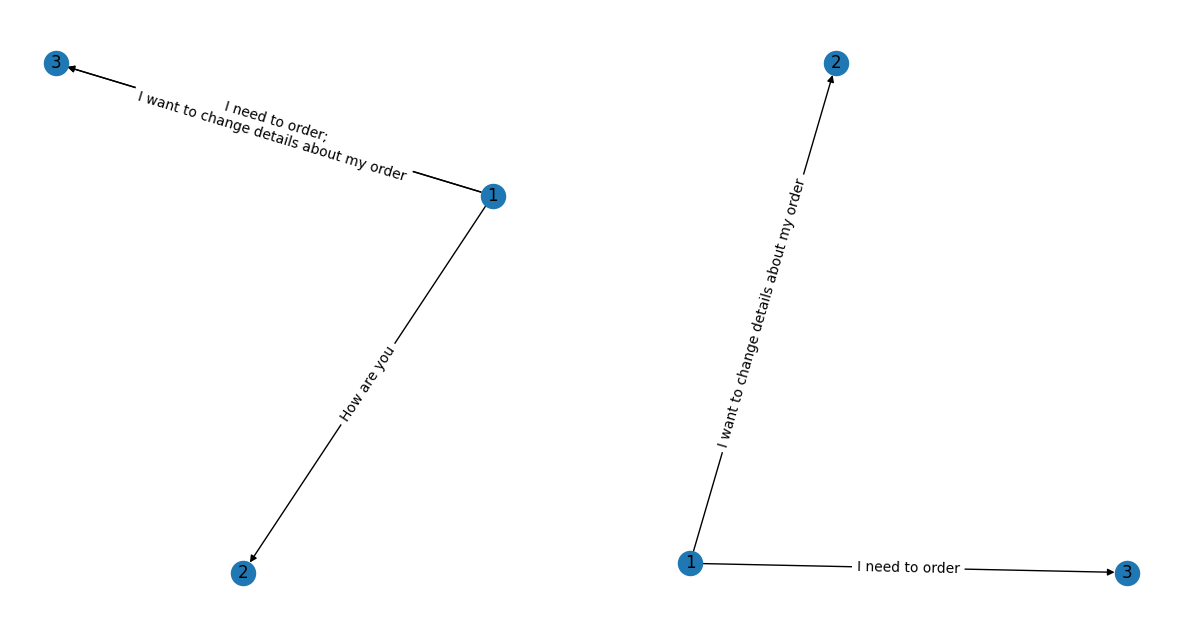

In [52]:
# pos = nx.spring_layout(G1)
plt.figure(figsize=(15,8))
subax1 = plt.subplot(121)
# nx.draw(G1, with_labels=True, font_weight='bold')
pos = nx.spring_layout(G1, k=5)
nx.draw(G1, pos, with_labels=True)
g1_edge_labels = get_edge_labels(G1)
nx.draw_networkx_edge_labels(G1, pos, edge_labels=g1_edge_labels, label_pos=0.5, font_size=10)

subax2 = plt.subplot(122)
pos2 = nx.spring_layout(G2, k=5)
nx.draw(G2, pos2, with_labels=True)
g2_edge_labels = get_edge_labels(G2)
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=g2_edge_labels, label_pos=0.5, font_size=10)
plt.show()

In [243]:
do_mapping(G1, G2)

in g1 Node 3 is split into [3, 2] in g2
{3: [3, 2]}
{}
{1: 1, 2: None, 3: 3}


## Метрика

In [63]:
def collapse_multiedges(edges):
    collapsed_edges = {}
    for u, v, data in edges:
        key=f'{u}->{v}'
        if key not in collapsed_edges:
            collapsed_edges[key] = []
        collapsed_edges[key].append(*data.values())
    return collapsed_edges

In [81]:
def jaccard_edges(edges1, edges2, verbose=False):
    edges1 = list(edges1)
    edges2 = list(edges2)
    
    collapsed_edges1 = collapse_multiedges(edges1)
    collapsed_edges2 = collapse_multiedges(edges2)

    jaccard_values = np.zeros((len(collapsed_edges1), len(collapsed_edges1)))
    
    for idx1, (k1, v1) in enumerate(collapsed_edges1.items()):
        for idx2, (k2, v2) in enumerate(collapsed_edges2.items()):
            value1 = set(v1).intersection(set(v2))
            value2 = set(v1).union(set(v2))

            if verbose:
                print(k1, v1)
                print(k2, v2)
                print(value1, value2)
                print("___")
            
            jaccard_values[idx1][idx2] = len(value1) / len(value2)
    if verbose:
        print(jaccard_values)
    max_jaccard_values = np.max(jaccard_values, axis=1)
    edges_maximising_jaccard_values = np.argmax(jaccard_values, axis=1)
    return max_jaccard_values, edges_maximising_jaccard_values

In [51]:
def jaccard_nodes(nodes1, nodes2, verbose=False):
    jaccard_values = np.zeros((len(nodes1) + 1, len(nodes2) + 1))
    for node1 in nodes1:
        for node2 in nodes2:
            
            node1_id = node1[0]
            node2_id = node2[0]

            if type(node1[1]['responses']) is str:
                node1_resp = [node1[1]['responses']]
            else:
                node1_resp = node1[1]['responses']

            if type(node2[1]['responses']) is str:
                node2_resp = [node2[1]['responses']]
            else:
                node2_resp = node2[1]['responses']                 

            value1 = set(node1_resp).intersection(set(node2_resp))
            value2 = set(node1_resp).union(set(node2_resp))
            
            jaccard_values[node1_id][node2_id] = len(value1) / len(value2)

            if verbose:
                print(node1[1]['responses'])
                print(node2[1]['responses'])
                print(value1, value2)
                print("_____")
    if verbose:
        print(jaccard_values)
    max_jaccard_values = np.max(jaccard_values, axis=1)
    nodes_maximising_jaccard_values = np.argmax(jaccard_values, axis=1)
    return max_jaccard_values, nodes_maximising_jaccard_values

In [58]:
list(G1.edges(data=True))

[(1, 3, {'requests': 'I need to order'}),
 (1, 3, {'requests': 'I want to change details about my order'}),
 (1, 2, {'requests': 'How are you'})]

In [82]:
jaccard_edges(G1.edges(data=True), G2.edges(data=True))

1->3 ['I need to order', 'I want to change details about my order']
1->3 ['I need to order']
___
1->3 ['I need to order', 'I want to change details about my order']
1->2 ['I want to change details about my order']
___
1->2 ['How are you']
1->3 ['I need to order']
___
1->2 ['How are you']
1->2 ['I want to change details about my order']
___
[[0.5 0.5]
 [0.  0. ]]


(array([0.5, 0. ]), array([0, 0]))

In [52]:
jaccard_nodes(G1.nodes(data=True), G2.nodes(data=True))

(array([0., 1., 0., 0.]), array([0, 1, 0, 0]))

## Дополнение графа

In [88]:
with open('./subgraph_metric_calc/initial_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./subgraph_metric_calc/gpt_response.json', 'r') as g:
    generated = json.load(g)

In [91]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

In [92]:
G1.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8))

In [110]:
for elem in list(G1.edges(data=True)):
    print(elem)

(1, 2, {'requests': 'I need to make an order'})
(1, 2, {'requests': 'I want to order'})
(2, 3, {'requests': "I would like to purchase 'Anna Karenina', please"})
(2, 3, {'requests': 'I need Crime and Punishment'})
(2, 4, {'requests': 'Do you have War and Piece?'})
(2, 4, {'requests': "Do you have Tolstoy's diaries?"})
(3, 2, {'requests': 'Yes, I also need a book Cathing in the Rye'})
(3, 7, {'requests': "No, that's all"})
(4, 5, {'requests': 'Yes'})
(4, 6, {'requests': 'No'})
(5, 2, {'requests': 'Yes, I also need a book Cathing in the Rye'})
(5, 7, {'requests': "No, that's all"})
(6, 2, {'requests': 'I need a book Cathing in the Rye'})
(6, 7, {'requests': "No, that's all"})
(7, 8, {'requests': 'Thanks'})
(7, 8, {'requests': 'Goodbye'})


In [109]:
for elem in list(G2.edges(data=True)):
    print(elem)

(1, 2, {'requests': 'I need to make an order'})
(1, 2, {'requests': 'I want to order'})
(2, 3, {'requests': 'Do you have War and Piece?'})
(2, 3, {'requests': "Do you have Tolstoy's diaries?"})
(2, 8, {'requests': "I would like to purchase 'Anna Karenina', please"})
(3, 4, {'requests': 'Yes'})
(3, 5, {'requests': 'No'})
(4, 2, {'requests': 'Yes, I also need a book Cathing in the Rye'})
(4, 6, {'requests': "No, that's all"})
(5, 2, {'requests': 'I need a book Cathing in the Rye'})
(5, 6, {'requests': "No, that's all"})
(6, 7, {'requests': 'Thanks'})
(6, 7, {'requests': 'Goodbye'})
(8, 2, {'requests': 'Yes, I also need a book Catching in the Rye'})
(8, 6, {'requests': "No, that's all"})


In [96]:
do_mapping(G1, G2)

KeyError: '2->4'

In [108]:
GM = nx.isomorphism.DiGraphMatcher(G1, G2, edge_match=lambda x, y: set(x['requests']).intersection(set( y['requests'])) is not None)
GM.is_isomorphic()


False

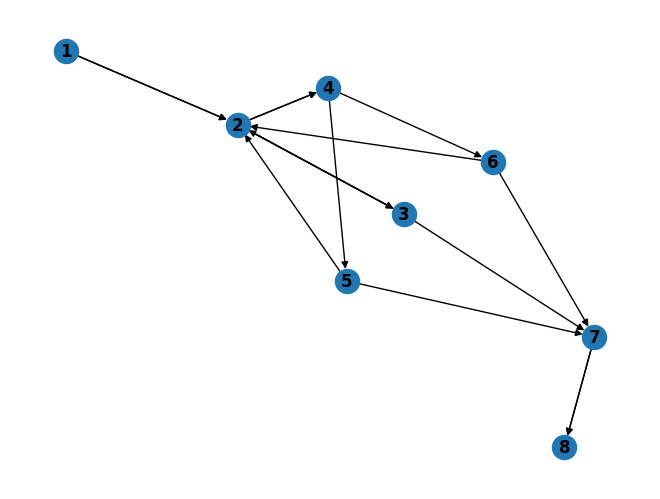

In [104]:

# subax1 = plt.subplot(121)
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, font_weight='bold')
# subax2 = plt.subplot(122)
# nx.draw(G2, with_labels=True, font_weight='bold')

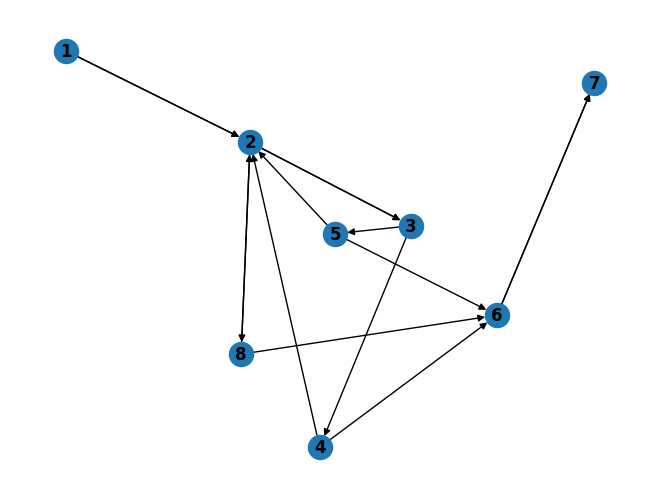

In [106]:
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, font_weight='bold')